<center>
    <h1> INF491 - Astroinformatics </h1>
    <h2> WavClumps Project:  A Wavelet based algorithm to find clumps and its structure </h2>
    <h3> Martín Villanueva A. <sup>1</sup></h3>
</center>

[1] _martin.villanueva@alumnos.usm.cl - DI UTFSM - June 2016._

## Table of Contents
* [Introduction](#intro)
* [Proposed Solution](#proposal)
* [Concept Test and Experiments](#tests)

<div id='intro' />
## Introduction

In concise words the problem to be addressed consists on given a 3D spectroscopic cube of data (mostly from observations of cold molecular clouds), build an algorithm that automatically can identify clump structures, and determine the hierarchical relationships between them. **Why?**

* Manual methods **doesn’t scale** as fast as the generation of new data observations.
* Size of the images is **huge** and could contain hundreds/thousands of cores.
* Clump identification performed (manually) by astronomers usually didn’t match (**biased methods**).
* Determine the hierarchical relationships between the found clumps is fundamental to understand processes like the **star formation**.
* Clumping algorithms **(GaussClump, ClumpFind, FellWalker)** do not face the problem of finding hierarchical structures.
* State of the Art algorithm that that face this problem (Gregorio et al.) have only worked with **2D data** (collapsed cubes).

<div id='proposal' />
## Proposed Solution

The proposed approach is the natural extension of Gregorio et al. to 3D spectroscopic data cubes. The solution outline of the methods is shown in the next image:
<img src="files/wavclump.png" style="width: 500px;">
As you can see, it corresponds to a **multi-stage** algorithm with the following steps:

1. *Multiresolution Analysis* (**MRA**) is performed through a 3D Discrete Wavelet Transform (**3D-DWT**), to extract the features at different scales/frequencies.
2. For each computed cube approximation a 3D clump *identification/segmentation* algorithm is applied, in order to find structures on each level.
3. The results of each level will be (in some way) linked, according to his hierarchical structure. This will be summarized in a *tree structure* like a **Dendrogram**

### 1. Multiresolution Analysis through 3D-DWT

MRA is achieved by computing the 3D-DWT for the data cube at different levels, and then reconstructing the image with the approximation coefficients obtained at each level.

**1) 1D-DWT.** Starting from a signal s of length N, two sets of coefficients are computed: approximation coefficients CA1, and detail coefficients CD1. These vectors are obtained by convolving s with the low-pass filter Lo_D for approximation and with the high-pass filter Hi_D for detail, followed by *dyadic decimation*.
<img src="files/1Ddwt.gif" style="width: 500px;">

**2) 2D-DWT.** This two-dimensional DWT leads to a decomposition of approximation coefficients at level j in four components: the _approximation_ at level j + 1, and the details in three orientations (_horizontal_, _vertical_, and _diagonal_). The following chart describes the basic decomposition steps for images:
<img src="files/2Ddwt.gif" style="width: 500px;">

### 2. Clump indentification/segmentation

To perform this step two classic algorithms will be used:
1. **ClumpFind.** The algorithm works by contouring the data at multiples of the rms noise of the observations. It starts from the highest level, where isolate cores are identified and each of these is considered as new clump. Then this step is repeated by gradually decreasing the level where to search, identifying isolate structures and connecting them with clumps identified at previous levels, or defining them as new clumps otherwise.
<img src="files/cf.png" style="width: 300px;">

2. **FellWalker.** The algorithms works by computing ascent paths (with the highest gradient) for each single pixel. These paths have two alternatives: 1) Reach a local peak and so find a new clump. 2) Reach another ascent path computed previously, and so assign the pixels on that path to the corresponding (crashed) clump.
<img src="files/fw.png" style="width: 300px;">

**Observation.** An important feature must be taken into account: At higher levels (and lower frequencies) the resulting images are **much more easy/trivial to segmentate!**. Let's see for example, the MRA performed over a FITS image of Orion Methanol observations (slices at frequencies are shown).

**Level 0** (original data)
<img src="files/level0.png" style="width: 800px;">
**Level 1**
<img src="files/level1.png" style="width: 800px;">
**Level 2**
<img src="files/level2.png" style="width: 800px;">
**Level 3**
<img src="files/level3.png" style="width: 800px;">
it is clear that in the high levels the clump structures are much more easy to identify that the ones in lower levels. **Then simpler algorithms could be used!** as those of *computer vision/image processing*: **Simple Thresholding**, **Watershed algorithm**, etc. The only **complication** is that (some of them) must be **adapted** for 3D data.

### 3. Hierarchical relations
In order to determine how clumps at different levels are related to each other, the following methods could be used:
1. If the max pixel of a clump in the level $i$ it's contained on a clump at level $i+1$, then we say we say that clump al level $i$ proceeds from the corresponding clump at level $i+1$.
2. The other alternative is to find the **center of mass** of clump at level $i$, and similarly if it is contained on a clump at level $i+1$, then the relationship is inferred.
The results of such process are summarized in a tree-like structure (Dendrogram).

<div id='tests' />
## Concept Test and Experiments

In [1]:
%matplotlib inline

import sys
import os
import numba
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matlab.engine
from joblib import Parallel, delayed

sys.path.append('../../ACALIB/')
from acalib import acontainer as ac
from acalib.io import graph as gp

sys.path.insert(0, './clumping')
import fellwalker as fwalker

### Matlab engine

In [2]:
eng = matlab.engine.start_matlab()

### Testing some wavelets

In first place let's see the efects of applying 3D-DWT on a FITS image to perform multiresolution analysis, with different Wavelets families. 

In [41]:
eng.wavemenu(nargout=0)

### Visualizing some wavelets

In [4]:
psi,xval = eng.wavefun('morl',10, nargout=2)
eng.plot(xval, psi, nargout=0)

### Loading FITS data

In [3]:
"""
Loading data
"""
#fits_path = '../test_fits/ALMA00000103.fits'
#fits_path = '../test_fits/ALMA01000740.fits'
fits_path = '../test_fits/Orion.methanol.cbc.contsub.image.fits'

if os.path.isfile(fits_path):
    ml_data = eng.load_fits(fits_path)
    np_data = np.asarray(ml_data)
    np_data = ma.masked_array(np_data, mask=np.isnan(np_data))
else: print("FITS file doesn't exist")

In [4]:
app = eng.mra(ml_data, 'sym2', 3, nargout=1)

In [6]:
fw = fwalker.FellWalker()
caa,clumps,peaks,rms = fw.run(np_data, flat_verification=False, verbose=True)

INFO: Estimating RMS [fellwalker]
INFO: CAA initialized successfully [fellwalker]
INFO: [Stage 1] Removing small isolated regions [fellwalker]
INFO: [Stage 2] Walking up! [fellwalker]
INFO: Number of clumps found: 119 [fellwalker]
INFO: [Stage 3] Removing small clumps [fellwalker]
INFO: Number of remaining clumps: 88 [fellwalker]
INFO: [Stage 4] Merging clumps with low dip [fellwalker]
INFO: Number of remaining clumps: 24 [fellwalker]
INFO: [Stage 5] Smoothing boundaries [fellwalker]


In [52]:
class WavClumps():
    def __init__(self, wavelet='sym5', nlevel=4, clumping_method='fellwalker', keep_rms=False, n_jobs=2):
        self.wavelet = wavelet
        self.nlevel = nlevel
        self.clumping_method = clumping_method
        self.keep_rms = keep_rms
        self.n_jobs = n_jobs
        #setting default params
        self.default_params()
    
    def default_params(self):
        pass
    
    def mra(self, ml_data):
        """
        Computes approximations and details for each level
        """
        _approx = eng.mra(ml_data, self.wavelet, self.nlevel, nargout=1)
        
        #casting to numpy.ndarray
        approx = map(np.asarray, _approx)
        del _approx
        for i in range(len(approx)):
            approx[i] = ma.masked_array(approx[i], mask=np.isnan(approx[i]))
        return approx
    
    def tree_build(self, caa, clumps, peaks):
        #build the hierarchical tree
        htree = []
        for lvl in range(self.nlevel-1,-1,-1):
            tree = empty_tree(clumps[lvl+1].keys())
            for ind1,pk in peaks[lvl].items():
                for ind2,clump in clumps[lvl+1].items():
                    if contained(pk,clump):
                        tree[ind2].append(ind1)
                        break
            htree.append(tree)
        return htree
    
    
    def run(self, np_data, ml_data):
        #perform multiresolution analysis
        approx = self.mra(ml_data)
        approx.insert(0, np_data)
        
        #compute RMS of original data
        if self.keep_rms:
            rms = np.sqrt(np.sum(np_data*np_data) / np.size(np_data))
        
        #apply the clumping algorithm at all scales
        if self.keep_rms:
            parallelizer = Parallel(n_jobs=self.n_jobs)
            # this iterator returns the functions to execute for each task
            tasks_iterator = [delayed(clumping)(data, rms=rms) for data in approx]
            result = parallelizer(tasks_iterator)            
        else:
            parallelizer = Parallel(n_jobs=self.n_jobs)
            # this iterator returns the functions to execute for each task
            tasks_iterator = [delayed(clumping)(data) for data in approx]
            result = parallelizer(tasks_iterator)
        
        #perform clumping algorithm over original data and each approximation level
        caa = list()
        clumps = list()
        peaks = list()
        rmss = list()
        
        for res in result:
            caa.append(res[0])
            #parsing clumps pixel lists to numpy arrays
            for index in res[1]:
                pixel_list = res[1].pop(index)
                res[1][index] = np.asarray(pixel_list)
            clumps.append(res[1])
            #parsing peaks positions (tuples) to numpy arrays
            for index in res[2]:
                ppeak = res[2].pop(index)
                res[2][index] = np.asarray(ppeak)
            peaks.append(res[2])
            rmss.append(res[3])
        
        #build the hierarchical tree
        htree = self.tree_build(caa,clumps,peaks)
        
        max_pixels = []
        mean_pixels = []
        #compute clump associated structures
        for i in range(self.nlevel+1):
            max_val = 0
            acc_val = 0
            for pixels in clumps[i].values():
                npix = len(pixels)
                acc_val += npix
                if npix>max_val: max_val = npix
            acc_val /= len(clumps[i])
            max_pixels.append(max_val)
            mean_pixels.append(acc_val)
        
        #storing results 
        self.caa = caa
        self.clumps = clumps
        self.peaks = peaks
        self.rmss = rmss
        self.htree = htree
        self.max_pixels = max_pixels
        self.mean_pixels = mean_pixels
        return caa,clumps
    
    def summarize(self):
        for i in range(self.nlevel+1):
            print('Level {0}:'.format(i))
            print('Number of clumps: {0}'.format(len(self.clumps[i])))
            print('RMS of data cube: {0}'.format(self.rmss[i]))
            print('Number of pixels of bigger clump: {0}'.format(self.max_pixels[i]))
            print('Mean number of pixels of clums: {0}'.format(self.mean_pixels[i]))
            print('------------------------------------------')

In [53]:
def clumping(data, clumping_method='fellwalker', rms=None):
    if clumping_method=='fellwalker':
        fw = fwalker.FellWalker()
        if rms!=None:
            fw.par['RMS'] = rms
        res = fw.run(data, flat_verification=False)
        del fw
        return res
    elif clumping_method=='clumpfind':
        pass

In [54]:
@numba.jit('boolean (int64[:], int64[:,:])')
def contained(pixel, clump_pixels):
    retval = False
    for pp in clump_pixels:
        if pp[0]==pixel[0] & pp[1]==pixel[1] & pp[2]==pixel[2]:
            retval = True
            break
    return retval

In [55]:
def empty_tree(indexes):
    tree = dict()
    for ind in indexes:
        tree[ind] = list()
    return tree

### Instances with different Wavelet families

In [61]:
"""
Approach1: Different RMS at each level
"""
wc1 = WavClumps(wavelet='haar', nlevel=4)
wc2 = WavClumps(wavelet='db5', nlevel=4)
wc3 = WavClumps(wavelet='sym5', nlevel=4)
wc4 = WavClumps(wavelet='bior4.4', nlevel=4)
wc5 = WavClumps(wavelet='rbio4.4', nlevel=4)
wc6 = WavClumps(wavelet='coif3', nlevel=4)

"""
Approach2: Same RMS at each level (equal to RMS of level 0)
"""
_wc1 = WavClumps(wavelet='haar', nlevel=4, keep_rms=True)
_wc2 = WavClumps(wavelet='db5', nlevel=4, keep_rms=True)
_wc3 = WavClumps(wavelet='sym5', nlevel=4, keep_rms=True)
_wc4 = WavClumps(wavelet='bior4.4', nlevel=4, keep_rms=True)
_wc5 = WavClumps(wavelet='rbio4.4', nlevel=4, keep_rms=True)
_wc6 = WavClumps(wavelet='coif3', nlevel=4, keep_rms=True)

In [62]:
"""
Approach1: Different RMS at each level
"""
caa1, clumps1 = wc1.run(np_data, ml_data)
caa2, clumps2 = wc2.run(np_data, ml_data)
caa3, clumps3 = wc3.run(np_data, ml_data)
caa4, clumps4 = wc4.run(np_data, ml_data)
caa5, clumps5 = wc5.run(np_data, ml_data)
caa6, clumps6 = wc6.run(np_data, ml_data)

"""
Approach2: Same RMS at each level (equal to RMS of level 0)
"""
_caa1, _clumps1 = _wc1.run(np_data, ml_data)
_caa2, _clumps2 = _wc2.run(np_data, ml_data)
_caa3, _clumps3 = _wc3.run(np_data, ml_data)
_caa4, _clumps4 = _wc4.run(np_data, ml_data)
_caa5, _clumps5 = _wc5.run(np_data, ml_data)
_caa6, _clumps6 = _wc6.run(np_data, ml_data)

In [63]:
"""
Dictionary to handle results
"""
caa = {'haar':caa1, 'db5':caa2, 'sym5':caa3, 'bior4.4':caa4, 'rbio4.4':caa5, 'coif3':caa6}
_caa = {'haar':_caa1, 'db5':_caa2, 'sym5':_caa3, 'bior4.4':_caa4, 'rbio4.4':_caa5, 'coif3':_caa6}

### Some sumarizing results

In [64]:
"""
Haar wavelet
"""
wc1.summarize()

Level 0:
Number of clumps: 24
RMS of data cube: 0.188172825897
Number of pixels of bigger clump: 40514
Mean number of pixels of clums: 1850
------------------------------------------
Level 1:
Number of clumps: 16
RMS of data cube: 0.187593957118
Number of pixels of bigger clump: 23193
Mean number of pixels of clums: 1825
------------------------------------------
Level 2:
Number of clumps: 17
RMS of data cube: 0.186242311474
Number of pixels of bigger clump: 22371
Mean number of pixels of clums: 1728
------------------------------------------
Level 3:
Number of clumps: 8
RMS of data cube: 0.183928832705
Number of pixels of bigger clump: 15573
Mean number of pixels of clums: 2065
------------------------------------------
Level 4:
Number of clumps: 3
RMS of data cube: 0.180706110604
Number of pixels of bigger clump: 5213
Mean number of pixels of clums: 1973
------------------------------------------


In [65]:
"""
Daubechies wavelet
"""
wc2.summarize()

Level 0:
Number of clumps: 24
RMS of data cube: 0.188172825897
Number of pixels of bigger clump: 40514
Mean number of pixels of clums: 1850
------------------------------------------
Level 1:
Number of clumps: 23
RMS of data cube: 0.187891025937
Number of pixels of bigger clump: 27811
Mean number of pixels of clums: 1945
------------------------------------------
Level 2:
Number of clumps: 24
RMS of data cube: 0.187323677309
Number of pixels of bigger clump: 38872
Mean number of pixels of clums: 1880
------------------------------------------
Level 3:
Number of clumps: 12
RMS of data cube: 0.18554570891
Number of pixels of bigger clump: 42473
Mean number of pixels of clums: 3943
------------------------------------------
Level 4:
Number of clumps: 4
RMS of data cube: 0.182645274533
Number of pixels of bigger clump: 65027
Mean number of pixels of clums: 16718
------------------------------------------


In [66]:
"""
Near symmetric wavelet
"""
wc3.summarize()

Level 0:
Number of clumps: 24
RMS of data cube: 0.188172825897
Number of pixels of bigger clump: 40514
Mean number of pixels of clums: 1850
------------------------------------------
Level 1:
Number of clumps: 18
RMS of data cube: 0.187907770893
Number of pixels of bigger clump: 40697
Mean number of pixels of clums: 2477
------------------------------------------
Level 2:
Number of clumps: 27
RMS of data cube: 0.187274754928
Number of pixels of bigger clump: 39302
Mean number of pixels of clums: 1702
------------------------------------------
Level 3:
Number of clumps: 11
RMS of data cube: 0.185442388368
Number of pixels of bigger clump: 42936
Mean number of pixels of clums: 4387
------------------------------------------
Level 4:
Number of clumps: 5
RMS of data cube: 0.182420833442
Number of pixels of bigger clump: 64576
Mean number of pixels of clums: 13185
------------------------------------------


In [67]:
"""
Biorthogonal wavelet
"""
wc4.summarize()

Level 0:
Number of clumps: 24
RMS of data cube: 0.188172825897
Number of pixels of bigger clump: 40514
Mean number of pixels of clums: 1850
------------------------------------------
Level 1:
Number of clumps: 23
RMS of data cube: 0.187894261335
Number of pixels of bigger clump: 27452
Mean number of pixels of clums: 1936
------------------------------------------
Level 2:
Number of clumps: 28
RMS of data cube: 0.187328383478
Number of pixels of bigger clump: 38384
Mean number of pixels of clums: 1580
------------------------------------------
Level 3:
Number of clumps: 19
RMS of data cube: 0.185477321336
Number of pixels of bigger clump: 41029
Mean number of pixels of clums: 2436
------------------------------------------
Level 4:
Number of clumps: 6
RMS of data cube: 0.182919326345
Number of pixels of bigger clump: 56810
Mean number of pixels of clums: 9724
------------------------------------------


In [68]:
"""
Reverse biorthogonal wavelet
"""
wc5.summarize()

Level 0:
Number of clumps: 24
RMS of data cube: 0.188172825897
Number of pixels of bigger clump: 40514
Mean number of pixels of clums: 1850
------------------------------------------
Level 1:
Number of clumps: 18
RMS of data cube: 0.187920011671
Number of pixels of bigger clump: 40995
Mean number of pixels of clums: 2478
------------------------------------------
Level 2:
Number of clumps: 28
RMS of data cube: 0.187455463877
Number of pixels of bigger clump: 38835
Mean number of pixels of clums: 1602
------------------------------------------
Level 3:
Number of clumps: 19
RMS of data cube: 0.185666564189
Number of pixels of bigger clump: 43324
Mean number of pixels of clums: 2480
------------------------------------------
Level 4:
Number of clumps: 11
RMS of data cube: 0.182762191282
Number of pixels of bigger clump: 58710
Mean number of pixels of clums: 5577
------------------------------------------


In [69]:
"""
Coiflet Wavelet
"""
wc6.summarize()

Level 0:
Number of clumps: 24
RMS of data cube: 0.188172825897
Number of pixels of bigger clump: 40514
Mean number of pixels of clums: 1850
------------------------------------------
Level 1:
Number of clumps: 23
RMS of data cube: 0.187914730121
Number of pixels of bigger clump: 27511
Mean number of pixels of clums: 1941
------------------------------------------
Level 2:
Number of clumps: 26
RMS of data cube: 0.187303652202
Number of pixels of bigger clump: 39422
Mean number of pixels of clums: 1775
------------------------------------------
Level 3:
Number of clumps: 13
RMS of data cube: 0.185596683494
Number of pixels of bigger clump: 41967
Mean number of pixels of clums: 3686
------------------------------------------
Level 4:
Number of clumps: 5
RMS of data cube: 0.1828588722
Number of pixels of bigger clump: 63504
Mean number of pixels of clums: 13032
------------------------------------------


### Plots of principal indicators (Approach 1: Different RMS) 

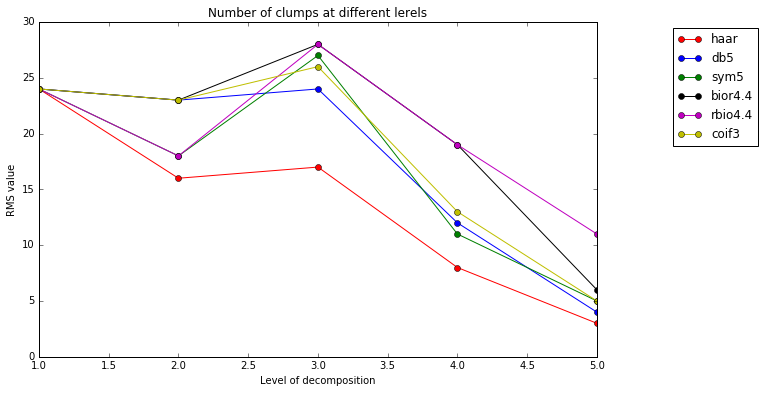

In [84]:
plt.figure(figsize=(10,6))
plt.plot([1,2,3,4,5], map(len,wc1.clumps), 'ro-', label='haar')
plt.plot([1,2,3,4,5], map(len,wc2.clumps), 'bo-', label='db5')
plt.plot([1,2,3,4,5], map(len,wc3.clumps), 'go-', label='sym5')
plt.plot([1,2,3,4,5], map(len,wc4.clumps), 'ko-', label='bior4.4')
plt.plot([1,2,3,4,5], map(len,wc5.clumps), 'mo-', label='rbio4.4')
plt.plot([1,2,3,4,5], map(len,wc6.clumps), 'yo-', label='coif3')
plt.title('Number of clumps at different lerels')
plt.ylabel('RMS value')
plt.xlabel('Level of decomposition')
plt.legend(bbox_to_anchor=(1.3, 1.0))
plt.show()

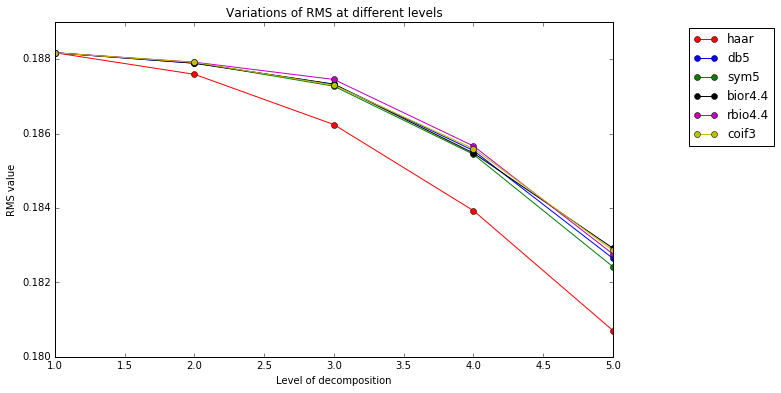

In [85]:
plt.figure(figsize=(10,6))
plt.plot([1,2,3,4,5], wc1.rmss, 'ro-', label='haar')
plt.plot([1,2,3,4,5], wc2.rmss, 'bo-', label='db5')
plt.plot([1,2,3,4,5], wc3.rmss, 'go-', label='sym5')
plt.plot([1,2,3,4,5], wc4.rmss, 'ko-', label='bior4.4')
plt.plot([1,2,3,4,5], wc5.rmss, 'mo-', label='rbio4.4')
plt.plot([1,2,3,4,5], wc6.rmss, 'yo-', label='coif3')
plt.title('Variations of RMS at different levels')
plt.ylabel('RMS value')
plt.xlabel('Level of decomposition')
plt.legend(bbox_to_anchor=(1.3, 1.0))
plt.show()

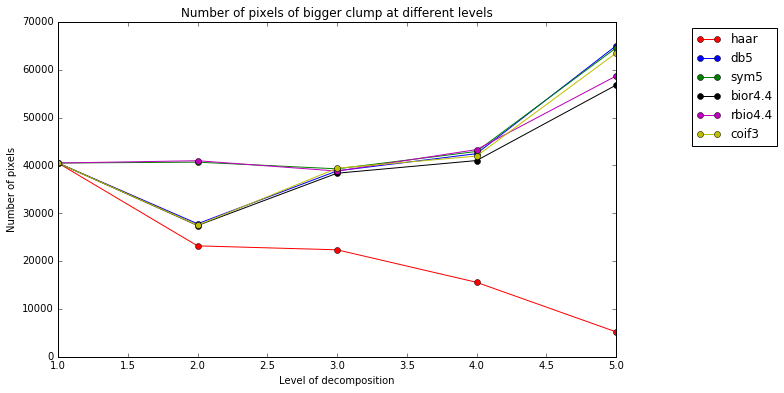

In [86]:
plt.figure(figsize=(10,6))
plt.plot([1,2,3,4,5], wc1.max_pixels, 'ro-', label='haar')
plt.plot([1,2,3,4,5], wc2.max_pixels, 'bo-', label='db5')
plt.plot([1,2,3,4,5], wc3.max_pixels, 'go-', label='sym5')
plt.plot([1,2,3,4,5], wc4.max_pixels, 'ko-', label='bior4.4')
plt.plot([1,2,3,4,5], wc5.max_pixels, 'mo-', label='rbio4.4')
plt.plot([1,2,3,4,5], wc6.max_pixels, 'yo-', label='coif3')
plt.title('Number of pixels of bigger clump at different levels')
plt.ylabel('Number of pixels')
plt.xlabel('Level of decomposition')
plt.legend(bbox_to_anchor=(1.3, 1.0))
plt.show()

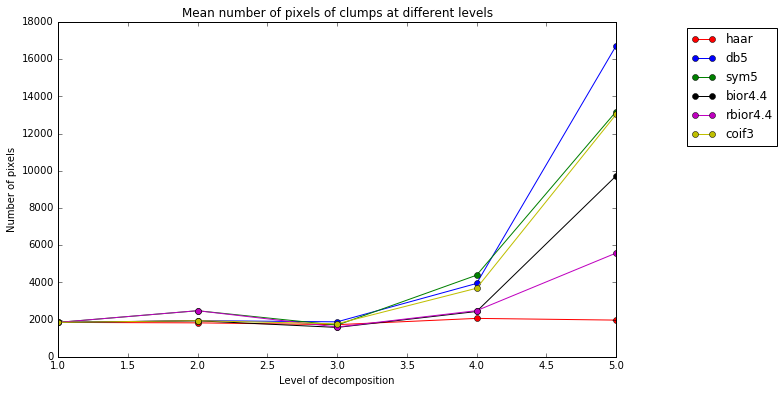

In [88]:
plt.figure(figsize=(10,6))
plt.plot([1,2,3,4,5], wc1.mean_pixels, 'ro-', label='haar')
plt.plot([1,2,3,4,5], wc2.mean_pixels, 'bo-', label='db5')
plt.plot([1,2,3,4,5], wc3.mean_pixels, 'go-', label='sym5')
plt.plot([1,2,3,4,5], wc4.mean_pixels, 'ko-', label='bior4.4')
plt.plot([1,2,3,4,5], wc5.mean_pixels, 'mo-', label='rbior4.4')
plt.plot([1,2,3,4,5], wc6.mean_pixels, 'yo-', label='coif3')
plt.title('Mean number of pixels of clumps at different levels')
plt.ylabel('Number of pixels')
plt.xlabel('Level of decomposition')
plt.legend(bbox_to_anchor=(1.3, 1.0))
plt.show()

### Plots of principal indicators (Approach 1: Same RMS as level 0) 

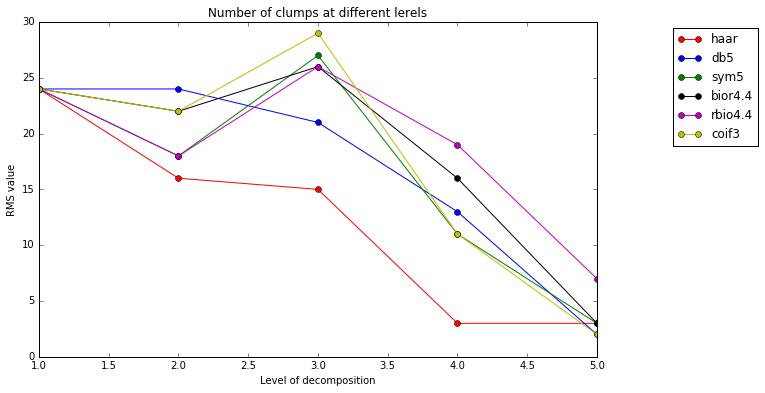

In [89]:
plt.figure(figsize=(10,6))
plt.plot([1,2,3,4,5], map(len,_wc1.clumps), 'ro-', label='haar')
plt.plot([1,2,3,4,5], map(len,_wc2.clumps), 'bo-', label='db5')
plt.plot([1,2,3,4,5], map(len,_wc3.clumps), 'go-', label='sym5')
plt.plot([1,2,3,4,5], map(len,_wc4.clumps), 'ko-', label='bior4.4')
plt.plot([1,2,3,4,5], map(len,_wc5.clumps), 'mo-', label='rbio4.4')
plt.plot([1,2,3,4,5], map(len,_wc6.clumps), 'yo-', label='coif3')
plt.title('Number of clumps at different lerels')
plt.ylabel('RMS value')
plt.xlabel('Level of decomposition')
plt.legend(bbox_to_anchor=(1.3, 1.0))
plt.show()

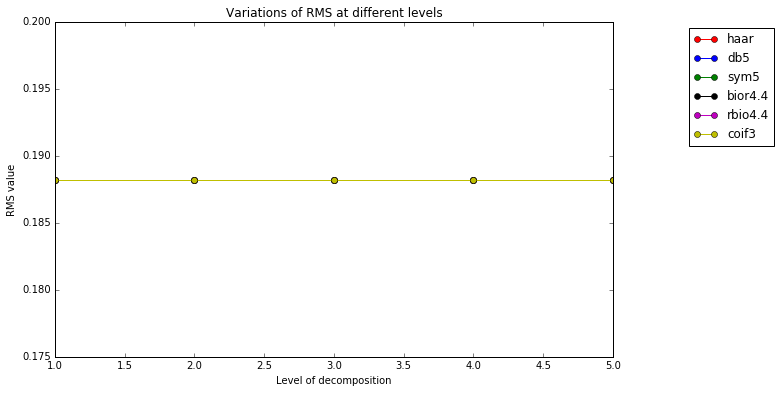

In [90]:
plt.figure(figsize=(10,6))
plt.plot([1,2,3,4,5], _wc1.rmss, 'ro-', label='haar')
plt.plot([1,2,3,4,5], _wc2.rmss, 'bo-', label='db5')
plt.plot([1,2,3,4,5], _wc3.rmss, 'go-', label='sym5')
plt.plot([1,2,3,4,5], _wc4.rmss, 'ko-', label='bior4.4')
plt.plot([1,2,3,4,5], _wc5.rmss, 'mo-', label='rbio4.4')
plt.plot([1,2,3,4,5], _wc6.rmss, 'yo-', label='coif3')
plt.title('Variations of RMS at different levels')
plt.ylabel('RMS value')
plt.xlabel('Level of decomposition')
plt.legend(bbox_to_anchor=(1.3, 1.0))
plt.show()

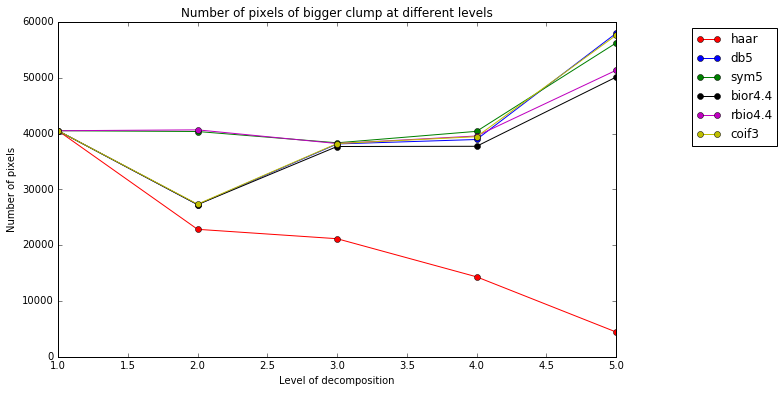

In [91]:
plt.figure(figsize=(10,6))
plt.plot([1,2,3,4,5], _wc1.max_pixels, 'ro-', label='haar')
plt.plot([1,2,3,4,5], _wc2.max_pixels, 'bo-', label='db5')
plt.plot([1,2,3,4,5], _wc3.max_pixels, 'go-', label='sym5')
plt.plot([1,2,3,4,5], _wc4.max_pixels, 'ko-', label='bior4.4')
plt.plot([1,2,3,4,5], _wc5.max_pixels, 'mo-', label='rbio4.4')
plt.plot([1,2,3,4,5], _wc6.max_pixels, 'yo-', label='coif3')
plt.title('Number of pixels of bigger clump at different levels')
plt.ylabel('Number of pixels')
plt.xlabel('Level of decomposition')
plt.legend(bbox_to_anchor=(1.3, 1.0))
plt.show()

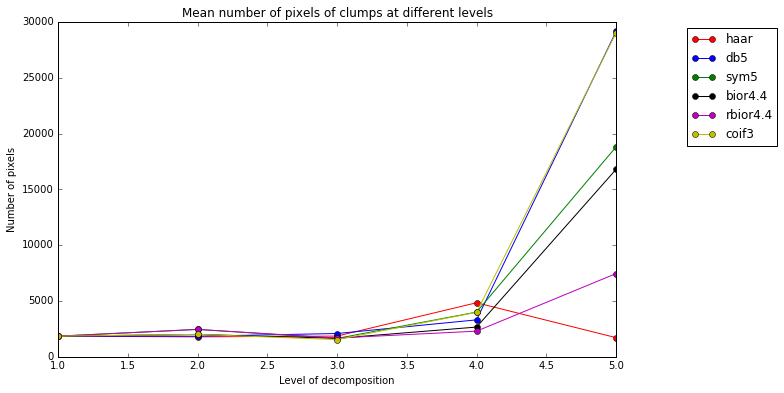

In [92]:
plt.figure(figsize=(10,6))
plt.plot([1,2,3,4,5], _wc1.mean_pixels, 'ro-', label='haar')
plt.plot([1,2,3,4,5], _wc2.mean_pixels, 'bo-', label='db5')
plt.plot([1,2,3,4,5], _wc3.mean_pixels, 'go-', label='sym5')
plt.plot([1,2,3,4,5], _wc4.mean_pixels, 'ko-', label='bior4.4')
plt.plot([1,2,3,4,5], _wc5.mean_pixels, 'mo-', label='rbior4.4')
plt.plot([1,2,3,4,5], _wc6.mean_pixels, 'yo-', label='coif3')
plt.title('Mean number of pixels of clumps at different levels')
plt.ylabel('Number of pixels')
plt.xlabel('Level of decomposition')
plt.legend(bbox_to_anchor=(1.3, 1.0))
plt.show()

### Some 2D graphical results

In [94]:
def show_caa_slices(caa, level, dslc=10):
    caa = np.copy(caa)
    caa[caa==-1] = 0
    maxf = caa.shape[2]
    idx_slices = np.linspace(dslc,maxf-dslc,9, dtype=np.int)
    plt.figure(figsize=(15,15))
    for i in range(9):
        f = idx_slices[i]
        plt.subplot(3,3,i+1)
        plt.imshow(caa[:,:,f])
        plt.xlabel('Freq = {0}'.format(f))
        if i==1:
            plt.title('CAA slices at level {0}'.format(level))
    plt.show()

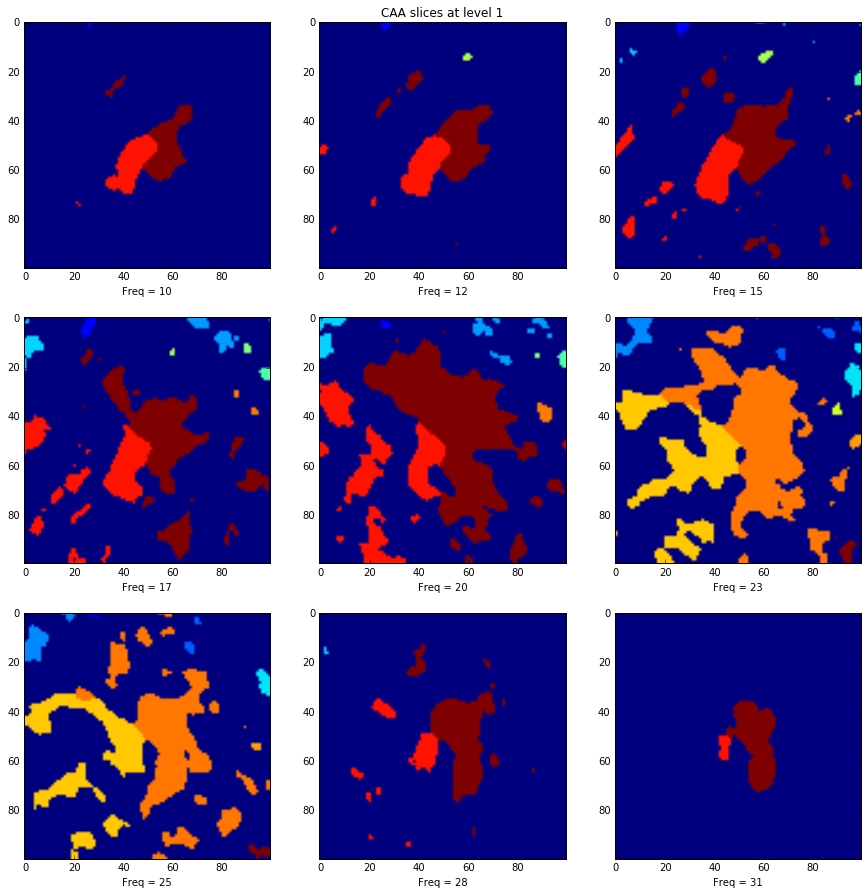

In [95]:
level = 1
show_caa_slices(caa['db5'][level], level)

### Some 3D graphical results

In [100]:
""""
Cube where to load CAAs
"""
cont=ac.AContainer()
cont.load('../../bindata/fits/cubes/Orion.methanol.cbc.contsub.image.fits')
cube=cont.primary.copy()

INFO: Processing HDU 0 (Image) [acalib.io.formats]
INFO: 4D data detected: assuming RA-DEC-FREQ-STOKES (like CASA-generated ones), and dropping STOKES [acalib.io.formats]


In [118]:
"""
clumps -> list of dictionary clumps
"""
def plot_clumps(clumps, plot='volume'):
    cube = cont.primary.copy()
    cube.data = np.zeros(cube.data.shape)
    for clump_id,pp in clumps.items():
        cube.data[pp.T[2],pp.T[1],pp.T[0]] = clump_id
    if plot=='volume': gp.volume(cube)
    elif plot=='contour': gp.contour(cube)
    del cube

In [119]:
plot_clumps(wc2.clumps[0])

### Visualizing the tree structure
Let's see the the hierarchical tree structure for results with _biorthogonal wavelet_.

In [103]:
wc2.htree[0]

{1: [2, 4], 2: [], 3: [], 4: []}